#### First, make sure that sgan is installed in your python environment.
I assume you have installed mapsgan in the same way (which is necessary too), so this might be familiar to you.
- Therefore, open a console, make a folder "sgan" in your project.
- Execute 'git clone https://github.com/jkoal/mapsgan.git'. I created a branch "sgan" in mapsgan with my annotated sgan code. A new repository for that would be a bit more elegant, but I am too lazy rn to do that. And a fork cant be private and I dont wanna go public with it. Make 'git checkout sgan' and make sure to stay on this branch in this directory.
- Activate your environment.
- Find out the env path by 'which python'. It is something like "~/anaconda3/envs/mapsgan/bin/python"
- Install package by creating a sgan.pth in site-packages which contains a single line to the sgan folder (the one with the "\__init\__.py" file). Easiest way to do so is when you are in the sgan directory, then type 'echo $PWD > /home/yy/anaconda3/envs/mapsgan/lib/python3.7/site-packages/sgan.pth' (path may vary). (Todo: add a setup file for the package.)


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
from mapsgan import SGANSolver, data_loader
from sgan import TrajectoryGenerator, TrajectoryDiscriminator
import mapsgan.experiments as experiments
from mapsgan.evaluation import Visualization

In [2]:
experiment = experiments.ETH() # we store filepaths and arguments in here
experiment.init_default_args() # those are some default SGAN parameters used in SGANSolver
dataset, trainloader = data_loader(in_len=8, out_len=12, batch_size=64, num_workers=1, path=experiment.test_dir)

In [3]:
generator = TrajectoryGenerator(obs_len=8,
                                pred_len=12,
                                embedding_dim=16,
                                encoder_h_dim=32,
                                decoder_h_dim=32,
                                mlp_dim=64,
                                num_layers=1,
                                noise_dim=(8,),
                                noise_type='gaussian',
                                noise_mix_type='global',
                                pooling_type='pool_net',
                                pool_every_timestep=1,
                                dropout=0,
                                bottleneck_dim=32,
                                neighborhood_size=2,
                                grid_size=8,
                                batch_norm=0)

discriminator = TrajectoryDiscriminator(obs_len=8,
                                        pred_len=12,
                                        embedding_dim=16,
                                        h_dim=64,
                                        mlp_dim=64,
                                        num_layers=1,
                                        dropout=0,
                                        batch_norm=0,
                                        d_type='local')

models = dict(generator = generator, discriminator = discriminator) # lmk if too cumbersome to pass both in a dict

In [4]:
solver = SGANSolver(models=models,experiment=experiment, # pls read the code and docstrings to get the idea
                loss_fns={'norm': nn.L1Loss, 'gan': nn.BCEWithLogitsLoss},
                optims_args={'generator': {'lr': 1e-2}, 'discriminator': {'lr': 1e-3}})

In [5]:
solver.train(trainloader, epochs = 10, checkpoint_every=1, steps = {'generator': 1, 'discriminator': 1})

G_gan: 0.691	G_norm: 16.564	G_total: 17.255	D_real: 0.693	D_fake: 0.693	D_total: 1.386	
G_gan: 0.693	G_norm: 15.785	G_total: 16.478	D_real: 0.690	D_fake: 0.702	D_total: 1.392	
G_gan: 0.693	G_norm: 17.065	G_total: 17.758	D_real: 0.692	D_fake: 0.693	D_total: 1.385	
G_gan: 0.693	G_norm: 13.877	G_total: 14.570	D_real: 0.692	D_fake: 0.693	D_total: 1.386	
G_gan: 0.691	G_norm: 11.680	G_total: 12.371	D_real: 0.691	D_fake: 0.695	D_total: 1.386	
G_gan: 0.693	G_norm: 11.842	G_total: 12.535	D_real: 0.692	D_fake: 0.696	D_total: 1.388	
G_gan: 0.693	G_norm: 10.882	G_total: 11.576	D_real: 0.692	D_fake: 0.693	D_total: 1.385	
G_gan: 0.693	G_norm: 8.331	G_total: 9.024	D_real: 0.693	D_fake: 0.693	D_total: 1.386	
G_gan: 0.693	G_norm: 7.509	G_total: 8.202	D_real: 0.692	D_fake: 0.694	D_total: 1.386	
G_gan: 0.693	G_norm: 6.998	G_total: 7.691	D_real: 0.692	D_fake: 0.693	D_total: 1.386	


#### Visualize things.
As we talked about, I implemented a simple plotting class that is supposed to integrate with the rest. E.g. vis.loss takes the dictionary 'solver.train_loss_history' of the solver object to plot all losses.
- For everything that you would like to visualize, think about how we could implement it in the class Visualization.

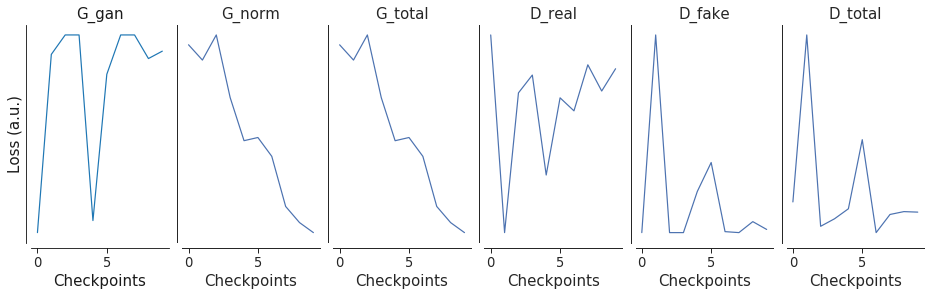

In [6]:
vis = Visualization()
vis.loss(solver.train_loss_history)